In [84]:
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer

In [85]:
df = pd.read_parquet('../../data/cleaned_tom/0317_ckpt/hi_tom_train_2000.parquet')
dfh = pd.read_parquet('../../data/cleaned_tom/0317_ckpt/hi_tom_explore_tom_test_hint.parquet')
dfe = pd.read_parquet('../data/ToM_train_1200.parquet')
dft = pd.read_parquet('../data/ToM_test_1066.parquet')

In [86]:
print(len(df), len(dfh), len(dfe))

2000 1600 1200


In [87]:
dfe['data_source'] = 'explore_tom'
dft['data_source'] = 'explore_tom'

In [88]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   deception       2000 non-null   bool  
 1   story_length    2000 non-null   int64 
 2   question_order  2000 non-null   int64 
 3   sample_id       2000 non-null   int64 
 4   story           2000 non-null   object
 5   question        2000 non-null   object
 6   choices         2000 non-null   object
 7   answer          2000 non-null   object
 8   question_old    2000 non-null   object
 9   answer_old      2000 non-null   object
 10  data_source     2000 non-null   object
 11  prompt          2000 non-null   object
 12  ability         2000 non-null   object
 13  reward_model    2000 non-null   object
 14  extra_info      2000 non-null   object
dtypes: bool(1), int64(3), object(11)
memory usage: 220.8+ KB


In [90]:
df.prompt[0]

array([{'content': '<|im_start|>system\nYou are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>. Now the user asks you to solve a theory of mind reasoning problem. After thinking, when you finally reach a conclusion, clearly state your answer within <answer> </answer> tags.\n<|im_end|>\n<|im_start|>user\nLily, Hannah, Emma, Jackson and Gracie entered the patio. The pumpkin is in the green_cupboard. Lily made no movements and stayed in the patio for 1 minute. Lily exited the patio. Hannah made no movements and stayed in the patio for 1 minute. Hannah exited the patio. Emma made no movements and stayed in the patio for 1 minute. Emma exited the patio. Jackson made no movements and stayed in the patio for 1 minute. Jacks

In [91]:
dfs = df.groupby(['answer']).story.count().reset_index()

In [92]:
#SYSTEM_PROMPT = """You are a helpful assistant. First, think through the question internally before providing the final answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> step by step reasoning here </think><answer> answer here </answer>"""

SYSTEM_PROMPT = """You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>."""

In [93]:
XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [94]:
def get_prompts(dft):
    prompt = []
    for i in range(len(dft)):
        if dft['data_source'][i] == 'explore_tom':
            prompt.append( [
                    {'role': 'system', 'content': SYSTEM_PROMPT},
                    {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story_structure'][i], dft['question'][i])}
                ])
        else:
            prompt.append( [
                    {'role': 'system', 'content': SYSTEM_PROMPT},
                    {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story'][i], dft['question'][i])}
                ])
    return prompt

In [95]:
prompts = get_prompts(df)
df['prompt'] = prompts

prompts = get_prompts(dfe)
dfe['prompt'] = prompts

prompts = get_prompts(dfh)
dfh['prompt'] = prompts

prompts = get_prompts(dft)
dft['prompt'] = prompts

In [96]:
dfe['story'] = dfe.story_structure
dft['story'] = dft.story_structure

In [139]:
dft.loc[dft.story.isna()]

,story_structure,infilled_story,question,answer,question_type,params,nth_order,is_interesting,story_type,story_structure_wn,data_source,prompt,story,extra_info


In [124]:
dft

,story_structure,infilled_story,question,answer,question_type,params,nth_order,is_interesting,story_type,story_structure_wn,data_source,prompt,story,extra_info
0,Justin entered the planning room. Justin moved...,"The planning room was dimly lit, the soft glow...",In which room does Justin think that Cameron w...,planning room,room_location-True,"(['Justin', 'Cameron'], 'wooden desk drawer', ...",2,False,tomi+object-state+asymmetric,1 Justin entered the planning room\n2 Justin m...,explore_tom,"[{'role': 'system', 'content': 'You are a help...",Justin entered the planning room. Justin moved...,"{'question_type': 'room_location-True', 'quest..."
1,Riley entered the hotel suite. Riley moved the...,"The luxurious hotel suite, with its polished w...",In which room does Addison think that Riley wi...,hotel suite,room_location-True,"(['Addison', 'Riley'], 'silver picture frame',...",2,False,tomi+object-state,1 Riley entered the hotel suite\n2 Riley moved...,explore_tom,"[{'role': 'system', 'content': 'You are a help...",Riley entered the hotel suite. Riley moved the...,"{'question_type': 'room_location-True', 'quest..."
2,Madison entered the press box. Madison retuned...,The sun began to set behind the sports stadium...,In which room does Madison think that Eric wil...,press box,room_location-True,"(['Madison', 'Eric'], 'walkie-talkie', 'room_l...",2,False,tomi-object-state,1 Madison entered the press box\n2 Madison ret...,explore_tom,"[{'role': 'system', 'content': 'You are a help...",Madison entered the press box. Madison retuned...,"{'question_type': 'room_location-True', 'quest..."
3,Mason entered the consulate meeting room. Maso...,"The consulate meeting room stood dimly lit, it...",In which container will Peyton search for the ...,leather briefcase,container_location-True,"(['Peyton'], 'silver letter opener', 'containe...",1,False,tomi+info-exchange,1 Mason entered the consulate meeting room\n2 ...,explore_tom,"[{'role': 'system', 'content': 'You are a help...",Mason entered the consulate meeting room. Maso...,"{'question_type': 'container_location-True', '..."
4,Cameron entered the planning room. Cameron mov...,The planning room was a cozy space filled with...,In which room does Cameron think that Olivia w...,planning room,room_location-True,"(['Cameron', 'Olivia'], 'canvas backpack', 'ro...",2,False,tomi,1 Cameron entered the planning room\n2 Cameron...,explore_tom,"[{'role': 'system', 'content': 'You are a help...",Cameron entered the planning room. Cameron mov...,"{'question_type': 'room_location-True', 'quest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,Olivia entered the library study room. Noah to...,The sun cast a warm glow over the university's...,In which container does Olivia think that Harp...,backpack,container_location-True,"(['Olivia', 'Harper'], 'pocket-sized notebook'...",2,False,all+asymmetric,1 Olivia entered the library study room\n2 Noa...,explore_tom,"[{'role': 'system', 'content': 'You are a help...",Olivia entered the library study room. Noah to...,"{'question_type': 'container_location-True', '..."
1062,Mia entered the hospital staff lounge. Jasmine...,"The hospital staff lounge was quiet, its only ...",In which container was the stethoscope at the ...,canvas bag,memory-container_location,"(None, 'stethoscope', 'memory-container_locati...",-1,True,tomi,1 Mia entered the hospital staff lounge\n2 Jas...,explore_tom,"[{'role': 'system', 'content': 'You are a help...",Mia entered the hospital staff lounge. Jasmine...,"{'question_type': 'memory-container_location',..."
1063,Emily entered the conservation lab. Emily move...,The museum's conservation lab was a quiet spac...,In which container will Emily search for the s...,velvet case,container_location-True,"(['Emily'], 'small, antique pocket watch', 'co...",1,False,tomi+asymmetric,1 Emily entered the conservation lab\n2 Emily ...,explore_tom,"[{'role': 'system', 'content': 'You are a help...",Emily entered the conservation lab. Emily 

In [97]:
dfe.head(2)

,story_structure,infilled_story,question,answer,question_type,params,nth_order,is_interesting,story_type,story_structure_wn,data_source,prompt,story
0,Jasmine entered the hospital staff lounge. Jas...,"The hospital staff lounge, a small room filled...",In which container does Amelia think that Madi...,wooden chest,container_location-True,"(['Amelia', 'Madison'], 'stethoscope', 'contai...",2,True,tomi+info-exchange+asymmetric,1 Jasmine entered the hospital staff lounge\n2...,explore_tom,"[{'role': 'system', 'content': 'You are a help...",Jasmine entered the hospital staff lounge. Jas...
1,Jasmine entered the hospital staff lounge. Jas...,"The hospital staff lounge, a small room filled...",In which container was the stethoscope before ...,canvas bag,memory_before_event-container_location,"(None, 'stethoscope', 'memory_before_event-con...",-1,True,tomi+info-exchange+asymmetric,1 Jasmine entered the hospital staff lounge\n2...,explore_tom,"[{'role': 'system', 'content': 'You are a help...",Jasmine entered the hospital staff lounge. Jas...


In [98]:
dfe.groupby(['is_interesting', 'question_type', ]).answer.count()

is_interesting  question_type                         
False           container_location-False                   11
                container_location-True                   162
                room_location-False                         4
                room_location-True                        423
True            container_location-False                   76
                container_location-True                    90
                ground_truth-container_location           118
                ground_truth-room_location                 21
                memory-container_location                 121
                memory-room_location                       19
                memory_before_event-container_location    146
                memory_before_event-room_location           3
                room_location-False                         2
                room_location-True                          4
Name: answer, dtype: int64

In [99]:
df.head(2)

,deception,story_length,question_order,sample_id,story,question,choices,answer,question_old,answer_old,data_source,prompt,ability,reward_model,extra_info
0,True,2,3,96,"Lily, Hannah, Emma, Jackson and Gracie entered...",Where does Lily think Gracie thinks Jackson th...,"A. green_drawer, B. red_container, C. blue_box...",green_cupboard,Where does Lily think Gracie thinks Jackson th...,green_cupboard,hi_tom,"[{'role': 'system', 'content': 'You are a help...",theory_of_mind,"{'ground_truth': 'green_cupboard', 'style': 'r...","{'deception': True, 'question_order': 3, 'stor..."
1,False,1,3,29,"Mila, Benjamin, Emily, Noah and Isabella enter...",Where does Noah think Emily thinks Mila thinks...,"A. red_crate, B. red_bottle, C. blue_drawer, D...",red_crate,Where does Noah think Emily thinks Mila thinks...,red_crate,hi_tom,"[{'role': 'system', 'content': 'You are a help...",theory_of_mind,"{'ground_truth': 'red_crate', 'style': 'rule'}","{'deception': False, 'question_order': 3, 'sto..."


In [100]:
col = ['prompt', 'answer', 'data_source', 'question', 'story']

In [101]:
dfr = pd.concat([df.loc[:, col], dfe.loc[:, col]], ignore_index=True)
dfr = dfr.sample(frac=1, replace=False, ignore_index=True)

In [123]:
dfr

,prompt,answer,data_source,question,story
0,"[{'role': 'system', 'content': 'You are a help...",blue_basket,hi_tom,Where does Evelyn really think the apple is?,"Oliver, Avery, Emma, Isabella and Evelyn enter..."
1,"[{'role': 'system', 'content': 'You are a help...",blue_basket,hi_tom,Where does Isabella think Benjamin thinks the ...,"Isla, Isabella, Benjamin, Jack and Gracie ente..."
2,"[{'role': 'system', 'content': 'You are a help...",leather briefcase,explore_tom,In which container will Liam search for the si...,Kaylee entered the hotel lobby. Kaylee moved t...
3,"[{'role': 'system', 'content': 'You are a help...",plastic storage bin,explore_tom,In which container was the waterproof flashlig...,Avery entered the control room. Avery moved th...
4,"[{'role': 'system', 'content': 'You are a help...",green_basket,hi_tom,Where does Alexander think Ava thinks Evelyn t...,"Ava, Emma, Evelyn, Avery and Alexander entered..."
...,...,...,...,...,...
3195,"[{'role': 'system', 'content': 'You are a help...",blue_basket,hi_tom,Where does Mason think Elizabeth thinks Noah t...,"Chloe, Noah, Isla, Elizabeth and Mason entered..."
3196,"[{'role': 'system', 'content': 'You are a help...",blue_bucket,hi_tom,Where is the sweet_potato really?,"Olivia lost his watch. Oliver, Charlotte, Mila..."
3197,"[{'role': 'system', 'content': 'You are a help...",blue_bathtub,hi_tom,Where does Ella really think the onion is?,"Ella dislikes the onion. Gracie, Oliver, Ameli..."
3198,"[{'role': 'system', 'content': 'You are a help...",red_crate,hi_tom,Where is the potato really?,"Ava, Emma, Jackson, Isabella and Evelyn entere..."


In [102]:
data = Dataset.from_pandas(dfr)

In [62]:
len(data['prompt'])

3200

<Axes: ylabel='Count'>

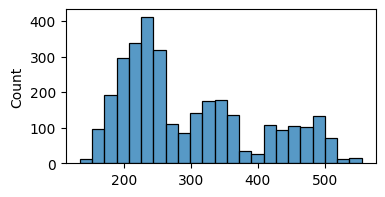

In [63]:
token_lengths = []
for prompt_list in data['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    # Tokenize the content
    tokens = tokenizer.apply_chat_template(prompt_list)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths)

In [64]:
data

Dataset({
    features: ['prompt', 'answer', 'data_source', 'question', 'story'],
    num_rows: 3200
})

In [65]:
data.to_parquet('../data/train/ToM_train_HiEx.parquet')

Creating parquet from Arrow format: 100%|██████████| 4/4 [00:00<00:00, 458.57ba/s]


7598692

**Verl**

In [66]:
SYSTEM_PROMPT

'You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>.'

In [67]:
# add a row to each data item that represents a unique id
def make_map_fn(split):

    def process_fn(example, idx):
        question = example.pop('question')
        story = example.pop('story')
        question = SYSTEM_PROMPT + f""" Read the following story and answer the question. Story: {story}\n Question:{question}"""

        solution = example.pop('answer')
        data = {
            "data_source": 'HiTom+ExploreTom',
            "prompt": [{
                "role": "user",
                "content": question
            }],
            "ability": "tom",
            "reward_model": {
                "style": "rule",
                "ground_truth": solution
            },
            "extra_info": {
                'split': split,
                'index': idx
            }
        }
        return data

    return process_fn

In [68]:
train_dataset_verl = data.map(function=make_map_fn('train'), with_indices=True)

Map: 100%|██████████| 3200/3200 [00:00<00:00, 36610.59 examples/s]


In [42]:
train_dataset_verl.to_parquet('../data/test/ToM_train_HiExTi_verl.parquet')

Creating parquet from Arrow format: 100%|██████████| 4/4 [00:00<00:00, 635.93ba/s]


4683079

In [111]:
extra_info = []
for i, row in dft.iterrows():
    extra_info.append({'question_type':row['question_type'], 
                       'question_order':row['nth_order'],
                       'is_interesting':row['is_interesting'],
                       'story_type':row['story_type']
                       })
dft['extra_info'] = extra_info

In [112]:
dfh[:1000].head(2)

,deception,story_length,question_order,sample_id,story,question,choices,answer,question_old,answer_old,...,reward_model,extra_info,story_structure,infilled_story,question_type,params,nth_order,is_interesting,story_type,story_structure_wn
0,False,1.0,4.0,89.0,"Benjamin, Emily, Mason, Evelyn and Jackson ent...",Where does Jackson think Benjamin thinks Emily...,"A. green_treasure_chest, B. green_bottle, C. g...",green_suitcase,Where does Jackson think Benjamin thinks Emily...,green_suitcase,...,"{'ground_truth': 'green_suitcase', 'style': 'r...","{'deception': False, 'question_order': 4, 'sto...",None,None,None,None,NaN,None,None,None
1,True,3.0,4.0,46.0,"Mason, Noah, Hannah, Ethan and Alexander enter...",Where does Hannah think Noah thinks Mason thin...,"A. green_box, B. blue_container, C. blue_pantr...",red_drawer,Where does Hannah think Noah thinks Mason thin...,red_drawer,...,"{'ground_truth': 'red_drawer', 'style': 'rule'}","{'deception': True, 'question_order': 4, 'stor...",None,None,None,None,NaN,None,None,None


In [113]:
test_tomi = load_dataset('parquet', data_files='../data/test/test_tomi.parquet')['train']

In [114]:
dftomi = pd.DataFrame(test_tomi)

In [115]:
dftomi.head(2)

,story,question,answer,question_type,question_type2,prompt
0,Jackson entered the hall. Chloe entered the ha...,Where was the boots at the beginning?,bathtub,true_belief,memory,[{'content': 'You are a helpful assistant. The...
1,Jackson entered the hall. Chloe entered the ha...,Where will Chloe look for the boots?,pantry,true_belief,first_order_1_no_tom,[{'content': 'You are a helpful assistant. The...


In [116]:
extra_info = []
for i, row in dftomi.iterrows():
    extra_info.append({'question_type':row['question_type'], 
                       'question_type2':row['question_type2']
                       })
dftomi['extra_info'] = extra_info

In [117]:
dftomi['data_source']='tomi'

In [118]:
col_test = ['prompt', 'answer', 'data_source', 'question', 'story', 'extra_info']

In [144]:
df_test = pd.concat([dft.loc[:, col_test], dfh.loc[dfh.data_source!='explore_tom', col_test], dftomi.loc[:, col_test]], ignore_index=True)
df_test = df_test.sample(frac=1, replace=False, ignore_index=True)

Exp 57	1009
72	928
876	5118



In [145]:
np.unique(df_test.story.isna())

array([False])

In [146]:
df_test.loc[df_test.story.isna()]

,prompt,answer,data_source,question,story,extra_info


In [147]:
df_test.loc[df_test.story=='None']

,prompt,answer,data_source,question,story,extra_info


In [148]:
len(df_test)

8060

In [149]:
df_test.groupby('story').question.count()

story
Abigail dislikes the pear Emma entered the playroom. Abigail entered the playroom. The pear is in the bucket. Emma exited the playroom. Lily entered the playroom. Abigail moved the pear to the treasure_chest. Emma entered the playroom.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [122]:
df_test

,prompt,answer,data_source,question,story,extra_info
0,"[{'role': 'system', 'content': 'You are a help...",red_box,hi_tom,Where is the cucumber really?,"Hannah, Emily, Olivia, Evelyn and Amelia enter...","{'deception': True, 'question_order': 0, 'stor..."
1,"[{'role': 'system', 'content': 'You are a help...",red_pantry,hi_tom,Where does Emily think Lily thinks Isabella th...,"Hannah, Chloe, Emily, Lily and Isabella entere...","{'deception': False, 'question_order': 4, 'sto..."
2,[{'content': 'You are a helpful assistant. The...,bucket,tomi,Where was the slacks at the beginning?,William entered the workshop. Logan entered th...,"{'question_type': 'true_belief', 'question_typ..."
3,[{'content': 'You are a helpful assistant. The...,cupboard,tomi,Where does Alexander think that Noah searches ...,Alexander entered the kitchen. Noah entered th...,"{'question_type': 'true_belief', 'question_typ..."
4,[{'content': 'You are a helpful assistant. The...,container,tomi,Where will Amelia look for the trousers?,Oliver hates the hat Charlotte entered the bat...,"{'question_type': 'second_order_false_belief',..."
...,...,...,...,...,...,...
8655,"[{'role': 'system', 'content': 'You are a help...",red_box,hi_tom,Where does Mason think Jackson thinks Oliver t...,"Jackson, Oliver, Avery, Mason and Aria entered...","{'deception': False, 'question_order': 4, 'sto..."
8656,[{'content': 'You are a helpful assistant. The...,drawer,tomi,Where will Jack look for the apple?,Jacob entered the dining_room. Jack loves the ...,"{'question_type': 'true_belief', 'question_typ..."
8657,"[{'role': 'system', 'content': 'You are a help...",cocktail lounge,explore_tom,In which room does William think that Ava will...,Ava entered the cocktail lounge. William enter...,"{'question_type': 'room_location-True', 'quest..."
8658,[{'content': 'You are a helpful assistant. The...,box,tomi,Where is the sweater really?,Hannah entered the playroom. Jacob entered the...,"{'question_type': 'second_order_false_belief',..."


In [150]:
data = Dataset.from_pandas(df_test)

data.to_parquet('../data/test/ToM_test_HiExTi.parquet')

Creating parquet from Arrow format: 100%|██████████| 9/9 [00:00<00:00, 465.72ba/s]


10798423

In [38]:
data_test = Dataset.from_pandas(df_test)

In [80]:
# add a row to each data item that represents a unique id
def make_map_fn_test(split):

    def process_fn(example, idx):
        question = example.pop('question')
        story = example.pop('story')
        question = SYSTEM_PROMPT + f""" Read the following story and answer the question. Story: {story}\n Question:{question}"""

        solution = example.pop('answer')
        data = {
            "prompt": [{
                "role": "user",
                "content": question
            }],
            "ability": "tom",
            "reward_model": {
                "style": "rule",
                "ground_truth": solution
            },
        }
        return data

    return process_fn

In [81]:
test_dataset_verl = data_test.map(function=make_map_fn_test('train'), with_indices=True)

Map: 100%|██████████| 8660/8660 [00:00<00:00, 27910.67 examples/s]


In [82]:
test_dataset_verl.to_parquet('../data/test/ToM_test_HiExTi_verl.parquet')

Creating parquet from Arrow format: 100%|██████████| 9/9 [00:00<00:00, 603.26ba/s]


9758322